# This notebook shows Poisson-Disc sampling on a single face and compares it with random sampling

In [1]:
from pyntcloud import PyntCloud
from pyntcloud.geometry.areas import *

import pandas as pd

from rotations import *
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [2]:
def is_on_face(s,a,b,c, debug=False):
    # s is the new point
    # function assumes the face has been transformed to the xy-plane
    as_x = s[0]-a[0]
    as_y = s[1]-a[1]

    s_ab = (b[0]-a[0])*as_y-(b[1]-a[1])*as_x < 0;

    if((c[0]-a[0])*as_y-(c[1]-a[1])*as_x > 0 == s_ab): 
        # is the point s to the left of or to the right of
        # both the lines AB and AC? If true, it can't be inside.
        if debug:
            print("not on face, case 1")
        return False

    if((c[0]-b[0])*(s[1]-b[1])-(c[1]-b[1])*(s[0]-b[0]) > 0 != s_ab): 
        # the point is between the "cones"
        # checking if point is outside the remaining boundary
        if debug:
            print("not on face, case 2")
        return False

    return True;


def find_width_height(v1,v2,v3):
    
    x_min, y_min, z_min, x_max, y_max, z_max = find_minmax(v1,v2,v3)
                
    width = (x_max-x_min)
    height = (y_max-y_min)
    return width, height

def find_minmax(v1,v2,v3):
    x_min = v1[0]
    x_max = v1[0]
    y_min = v1[1]
    y_max = v1[1]
    z_min = v1[2]
    z_max = v1[2]
    left_most = v1          
    # find x_min/max and y_min/max  
    for x,y,z in (v1, v2, v3):
        if x > x_max:
            x_max = x
        if x < x_min:
            x_min = x
        if y > y_max:
            y_max = y
        if y < y_min:
            y_min = y
        if z > z_max:
            z_max = z
        if z < z_min:
            z_min = z
    return x_min, y_min, z_min, x_max, y_max, z_max

In [3]:
#diamond = PyntCloud.from_file('cube.off')
diamond = PyntCloud.from_file('bed_0001.off')

v1, v2, v3 = diamond.get_mesh_vertices(False, False)

v1_xyz = v1[:, :3]
v2_xyz = v2[:, :3]
v3_xyz = v3[:, :3]

areas = triangle_area_multi(v1_xyz, v2_xyz, v3_xyz)
probabilities = areas / np.sum(areas)

v1 = v1_xyz[41] #Choosing an arbitrary face to test on
v2 = v2_xyz[41]
v3 = v3_xyz[41]

originals = (v1,v2,v3)

vertices = v1,v2,v3
other_vindex = [0,2]
if v1[0] <= v2[0]:
    left_most = 0
    other_vindex = [1,2]
else:
    left_most = 1
if v3[0] <= vertices[left_most][0]:
    left_most = 2
    other_vindex = [0,1]

print(vertices)

# Translate face such that origin_point is the origin
translation = vertices[left_most]
vertices = [np.subtract(p, translation) for p in vertices] # make list or dict eventually

# rotate the face to become the xy-plane
z_axis = (0.,0.,-1.)
AB = np.subtract(vertices[1], (0,0,0))
AC = np.subtract(vertices[2],vertices[left_most])

normal = np.cross(vertices[1], vertices[2])


rot_axis = np.cross(normal, z_axis)
if (np.linalg.norm(rot_axis) != 0): 
    # only perform the rotation if the plane was not xy to begin with!
    angle = np.arccos(np.dot(normal,z_axis)/(np.linalg.norm(normal)))
    angle = np.subtract(180,np.rad2deg(angle))
    vertices = [vrotate(p, angle, rot_axis) for p in vertices] # make list or dict eventually

v1,v2,v3 = vertices

print(v1,v2,v3)

(array([-30.5     , -42.527504, -12.25    ], dtype=float32), array([-30.      , -41.027504, -12.25    ], dtype=float32), array([-30.      , -42.527504, -12.25    ], dtype=float32))
[0. 0. 0.] [0.5 1.5 0. ] [0.5 0.  0. ]


[0. 0. 0.] [0.5 1.5 0. ] [0.5 0.  0. ]
[0. 0. 0.] [0.5 1.5 0. ] [0.5 0.  0. ]
(0.40216336235485733, 1.101034726701651) True


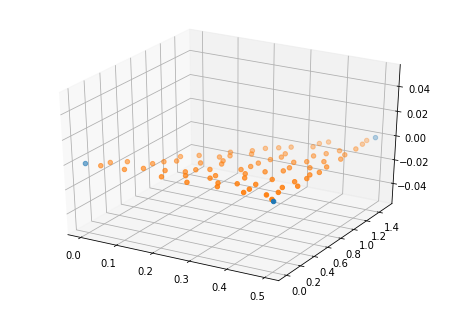

In [4]:

# Choose up to k points around each reference point as candidates for a new
# sample point
k = 50

# Minimum distance between samples
r = 0.06

#find width and height of a transformed triangle

width, height = find_width_height( v1, v2, v3 )


#shift vertices to make everything positive
y_min = find_minmax(v1,v2,v3)[1]
v1,v2,v3 = [np.subtract(p, (0,y_min,0)) for p in (v1,v2,v3)] # make list or dict eventually

# Cell side length
a = r/np.sqrt(2)
# Number of cells in the x- and y-directions of the grid
nx, ny = int(width / a) + 1, int(height / a) + 1

# A list of coordinates in the grid of cells
coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
# Initilalize the dictionary of cells: each key is a cell's coordinates, the
# corresponding value is the index of that cell's point's coordinates in the
# samples list (or None if the cell is empty).
cells = {coords: None for coords in coords_list}

def get_cell_coords(pt):
    """Get the coordinates of the cell that pt = (x,y) falls in."""

    return int(pt[0] // a), int(pt[1] // a)

def get_neighbours(coords):
    """Return the indexes of points in cells neighbouring cell at coords.

    For the cell at coords = (x,y), return the indexes of points in the cells
    with neighbouring coordinates illustrated below: ie those cells that could 
    contain points closer than r.

                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo

    """

    dxdy = [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx and
                0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            # This cell is occupied: store this index of the contained point.
            neighbours.append(neighbour_cell)
    return neighbours

def point_valid(pt):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """

    cell_coords = get_cell_coords(pt)
    for idx in get_neighbours(cell_coords):
        nearby_pt = samples[idx]
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0]-pt[0])**2 + (nearby_pt[1]-pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True

def get_point(k, refpt):
    """Try to find a candidate point relative to refpt to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    while i < k:
        rho, theta = np.random.uniform(r, 2*r), np.random.uniform(0, 2*np.pi)
        pt = refpt[0] + rho*np.cos(theta), refpt[1] + rho*np.sin(theta), 0
        if not (0 <= pt[0] < width and 0 <= pt[1] < height):
            # This point falls outside the domain of the grid, so try again.
            continue
        if point_valid(pt) and is_on_face(pt, v1, v2, v3):
            return pt
        i += 1
    # We failed to find a suitable point in the vicinity of refpt.
    return False





# Pick a random point to start with.
pt = (np.random.uniform(0, width), np.random.uniform(0, height))
while (not is_on_face(pt, v1,v2,v3)):
    pt = (np.random.uniform(0, width), np.random.uniform(0, height))
    
print(pt, is_on_face(pt, v1,v2,v3,True))


samples = [pt]
vertices = [v1[0:2]]
vertices.append(v2)
vertices.append(v3)

# Our first sample is indexed at 0 in the samples list...
cells[get_cell_coords(pt)] = 0
# ... and it is active, in the sense that we're going to look for more points
# in its neighbourhood.
active = [0]

nsamples = 1
# As long as there are points in the active list, keep trying to find samples.
while active:
    # choose a random "reference" point from the active list.
    idx = np.random.choice(active)
    refpt = samples[idx]
    # Try to pick a new point relative to the reference point.
    pt = get_point(k, refpt)
    if pt:
        # Point pt is valid: add it to the samples list and mark it as active
        samples.append(pt)
        nsamples += 1
        active.append(len(samples)-1)
        cells[get_cell_coords(pt)] = len(samples) - 1
    else:
        # We had to give up looking for valid points near refpt, so remove it
        # from the list of "active" points.
        active.remove(idx)
   
#2D plot
# plt.scatter(*zip(*samples), color='g', alpha=0.6, lw=0)
# plt.scatter(*zip(*vertices), color='r', alpha=0.6, lw=0)
# plt.xlim(-0.25, width+0.25)
# plt.ylim(-0.25, height+0.25)
# plt.axis('on')
# plt.show()

#3D plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*zip(*vertices))
ax.scatter(*zip(*samples))
plt.show()

73


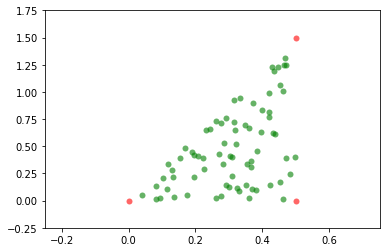

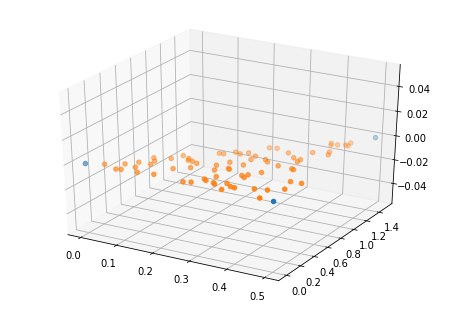

In [5]:
#random for comparison

N = len(samples)   #generate the same num points as poisson-disc
print(N)
samples = []
while N>0:
    pt = (np.random.uniform(0,width), np.random.uniform(0,height))
    if is_on_face(pt, v1, v2, v3):
        samples.append(pt)
        N-=1
        
#2D plot
plt.scatter(*zip(*samples), color='g', alpha=0.6, lw=0)
plt.scatter(*zip(*vertices), color='r', alpha=0.6, lw=0)
plt.xlim(-0.25, width+0.25)
plt.ylim(-0.25, height+0.25)
plt.axis('on')
plt.show()

#3D plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*zip(*vertices))
ax.scatter(*zip(*samples))
plt.show()

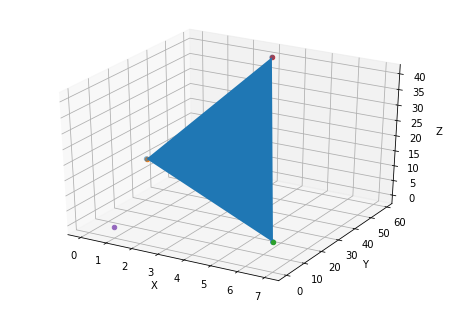

[(1, 18, 17), (7, 0, 7), (3, 59, 40)]


In [6]:
#testing translations back for rotation specificlaly
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

v1 = (1,18,17)
v2 = (7,0,7)
v3 = (3,59,40)
points = []
points.append(v1)
points.append(v2)
points.append(v3)


fig = plt.figure()
ax = Axes3D(fig)
verts = [list((v1,v2,v3))]
# print(verts)
ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(*zip(*(v1,v2,v3)))
ax.scatter(*v1)
ax.scatter(*v2)
ax.scatter(*v3)
ax.scatter(1,0,1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print((list(points)))





In [8]:
vertices = v1,v2,v3
other_vindex = [0,2]
if v1[0] <= v2[0]:
    left_most = 0
    other_vindex = [1,2]
else:
    left_most = 1
if v3[0] <= vertices[left_most][0]:
    left_most = 2
    other_vindex = [0,1]

print(vertices)

# Translate face such that origin_point is the origin
translation = vertices[left_most]
vertices = [np.subtract(p, translation) for p in vertices] # make list or dict eventually
#print(v1,v2,v3)    
print("pre rot", vertices)

# rotate the face to become the xy-plane
z_axis = (0.,0.,-1.)
AB = np.subtract(vertices[1], (0,0,0))
AC = np.subtract(vertices[2],vertices[left_most])

normal = np.cross(vertices[1], vertices[2])

print("T",vertices[1],vertices[2], vertices[0],normal)

rot_axis = np.cross(normal, z_axis)
if (np.linalg.norm(rot_axis) != 0): 
    # only perform the rotation if the plane was not xy to begin with!
    angle = np.arccos(np.dot(normal,z_axis)/(np.linalg.norm(normal)))
    angle = np.subtract(180,np.rad2deg(angle))
    vertices = [vrotate(p, angle, rot_axis) for p in vertices] # make list or dict eventually

v1,v2,v3 = vertices
print(vertices)


y_min = find_minmax(v1,v2,v3)[1]
v1,v2,v3 = [np.subtract(p, (0,y_min,0)) for p in (v1,v2,v3)] # make list or dict eventually


v1,v2,v3 = [np.add(p, (0,y_min,0)) for p in (v1,v2,v3)] # make list or dict eventually
vertices = v1,v2,v3

if (np.linalg.norm(rot_axis) != 0): 
    vertices = [vrotate(p, angle, -rot_axis) for p in vertices] # make list or dict eventually
    print("rev rot", vertices)
vertices = [np.add(p, translation) for p in vertices] # make list or dict eventually
#print(v1,v2,v3)    
print(vertices)

((1, 18, 17), (7, 0, 7), (3, 59, 40))
pre rot [array([0, 0, 0]), array([  6, -18, -10]), array([ 2, 41, 23])]
T [  6 -18 -10] [ 2 41 23] [0 0 0] [  -4 -158  282]
[array([0., 0., 0.]), array([ 5.93391388e+00, -2.06104019e+01, -5.32907052e-15]), array([2.15199808e+00, 4.70039243e+01, 1.42108547e-14])]
rev rot [array([0., 0., 0.]), array([  6., -18., -10.]), array([ 2., 41., 23.])]
[array([ 1., 18., 17.]), array([7., 0., 7.]), array([ 3., 59., 40.])]
